## Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import json
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.dates import DateFormatter
from matplotlib.patches import Polygon as matPolygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from shapely.geometry import Point, Polygon

## Clinic with main areas

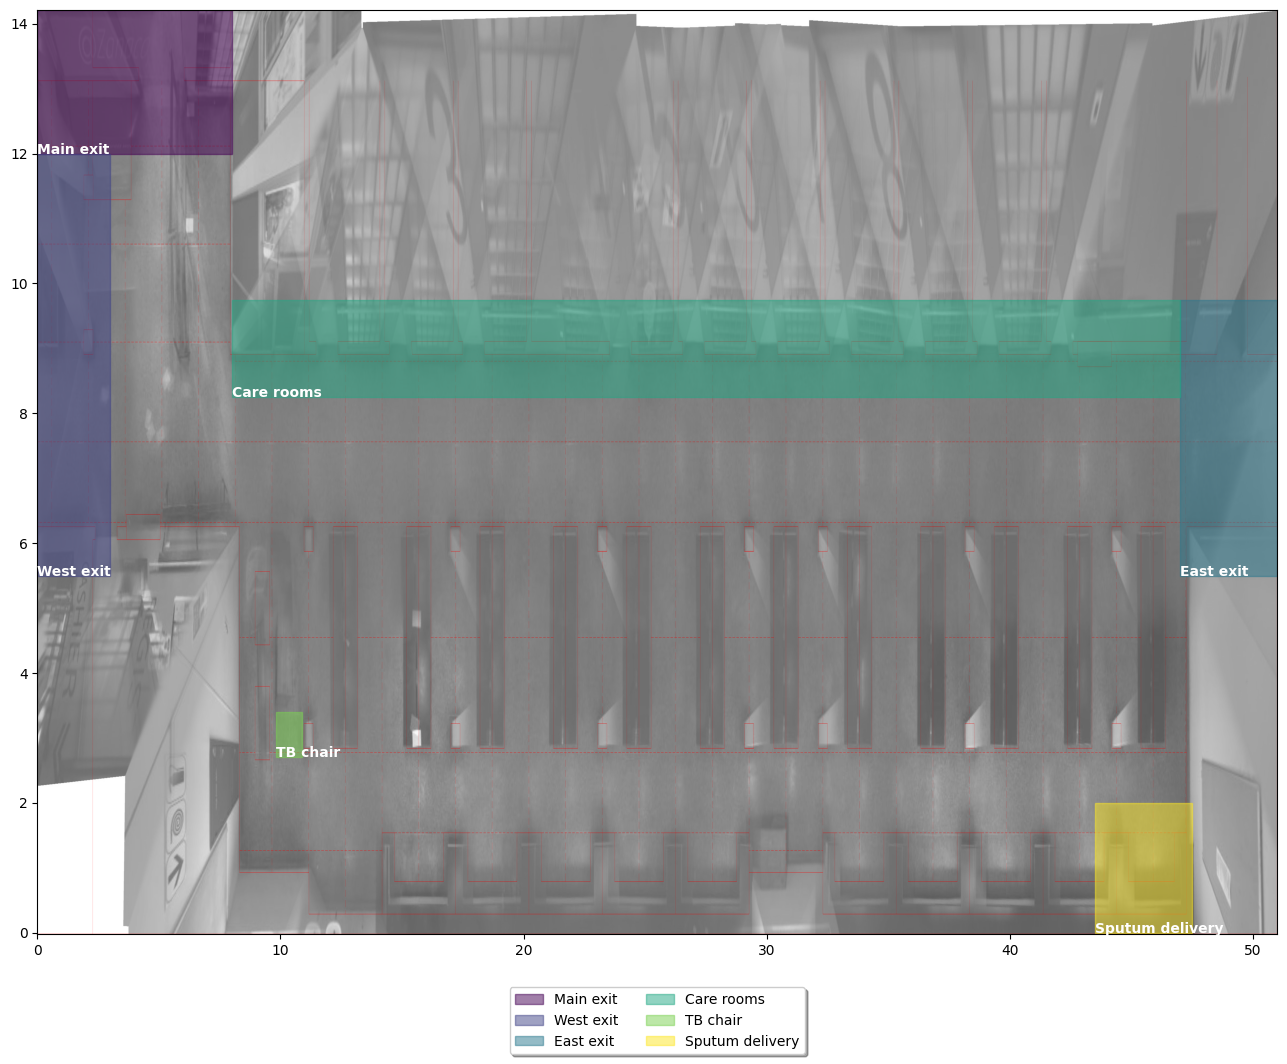

In [2]:
def plot_with_background(ax, alpha = .5):
	"""
	Creates a plot with a background image.

	Parameters:
	- ax: The matplotlib axis object containing the plot.
	"""
	# Path to your image file
	image_path = '../data-raw/background/image3195.png'
	
	# Coordinates for the image placement
	image_extent = (0, 51, -0.02, 14.214)

	# Load the background image
	img = mpimg.imread(image_path)
	
	# If an extent is provided, use it to correctly scale and position the image
	if image_extent:
		ax.imshow(img, aspect='auto', extent=image_extent, zorder=-1, alpha = alpha)
	else:
		ax.imshow(img, aspect='auto', zorder=-1, alpha = alpha)
	
	return ax

# Add geomtries
with open('../data-raw/background/config.json') as f:
	data = json.load(f)
geometries = []

# Entries and exits  
exit_top = [[0.0, 12.0], [8.0, 12.0], [8.0, 14.214], [0.0, 14.214]]
exit_top = {
	'geometry': exit_top,
	'type': 'ZONE',
	'name': 'Main exit'
}
geometries.append(exit_top)
exit_left = [[0.0, 5.5], [3.0, 5.5], [3.0, 12.0], [0.0, 12.0]]
exit_left = {
	'geometry': exit_left,
	'type': 'ZONE',
	'name': 'West exit'
}
geometries.append(exit_left)
exit_right = [[47.0, 5.5], [51.0, 5.5], [51.0, 9.75], [47.0, 9.75]]
exit_right = {
	'geometry': exit_right,
	'type': 'ZONE',
	'name': 'East exit'
}
geometries.append(exit_right)

# Care rooms
care_rooms = [[8.0, 8.25], [47.0, 8.25], [47.0, 9.75], [8.0, 9.75]]
care_rooms = {
	'geometry': care_rooms,
	'type': 'ZONE',
	'name': 'Care rooms'
}
geometries.append(care_rooms)

# TB survey area
tb_area = [[9.8, 2.7], [10.9, 2.7], [10.9, 3.4], [9.8, 3.4]]
tb_area = {
	'geometry': tb_area,
	'type': 'ZONE',
	'name': 'TB chair'
}
geometries.append(tb_area)

# Sputum area
sputum_area = [[43.5, 0], [47.5, 0], [47.5, 2.0], [43.5, 2.0]]
sputum_area = {
	'geometry': sputum_area,
	'type': 'ZONE',
	'name': 'Sputum delivery'
}
geometries.append(sputum_area)


def plot_with_background_geom(ax, geometries):
	"""
	Plots the geometries on a background image.

	Parameters:
	- ax: The matplotlib axes object where the plot will be drawn.
	- geometries: A list of geometry dictionaries, each containing 'geometry', 'type', and 'name' keys.

	Returns:
	- The modified axes object with the geometries plotted.
	"""
	# Plot the background image first
	ax = plot_with_background(ax, 1)

	# Color cycle for different polygons
	colors = plt.cm.viridis(np.linspace(0, 1, len(geometries)))

	for i, geometry in enumerate(geometries):
		# Extract the coordinates directly from the 'geometry' key
		coords = geometry['geometry']
		
		# Check if the geometry is a LINE or a ZONE to decide on closure
		if geometry['type'] == 'ZONE':
			closed = True
		else:  # For 'LINE', do not close the polygon
			closed = False
		
		# Create a polygon or line from the coordinates
		polygon = matPolygon(xy=coords, closed=closed, color=colors[i], label=geometry['name'], alpha=0.5)
		
		# Add the polygon or line to the plot
		ax.add_patch(polygon)
		
		# Label the polygon or line with its name
		# Use the first vertex for the label position
		ax.annotate(geometry['name'], xy=coords[0], color='white', weight='bold')

	# Adjust the legend to be below the plot
	ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

	return ax

fig, ax = plt.subplots(figsize=(16, 12))
ax = plot_with_background_geom(ax, geometries)
plt.show()

## Check number and order

In [3]:
# Load clinical 
tb_cases = pd.read_csv('../data-clean/clinical/tb_cases.csv')
tb_cases['start_time'] = pd.to_datetime(tb_cases['start_time'])
tb_cases['date'] = tb_cases['start_time'].dt.strftime('%Y-%m-%d')

# List all files in the directory
files = os.listdir('../data-clean/tracking/linked-tb/')

# Filter files that match the structure data.csv
filtered_files = [f for f in files if f.endswith('.csv')]

# Extract dates from the filenames
dates = [f.replace('.csv', '') for f in filtered_files]

# Create a dataframe with column dates
date_df = pd.DataFrame({'date': dates})

# For each date, get the number of rows in tb_cases
date_df['num_cases'] = date_df['date'].apply(lambda x: tb_cases[tb_cases['date'].str.startswith(x)].shape[0])

# For each date, load the corresponding file and filter rows with category == "sure"
date_df['tb_tracks'] = date_df['date'].apply(lambda x: pd.read_csv(f'../data-clean/tracking/linked-tb/{x}.csv').query('category == "sure"')['new_track_id'].nunique())
# Check if all integers from 1 to num_cases are present in the order for each date
def check_order(date, num_cases):
    df = pd.read_csv(f'../data-clean/tracking/linked-tb/{date}.csv')
    df_sure = df.query('category == "sure"')
    track_order = df_sure.drop_duplicates('new_track_id')['order'].tolist()
    track_order = set(track_order)
    case_order = set(map(str, range(1, num_cases + 1)))
    missing_integers = case_order - track_order
    if not missing_integers:
        return '0'
    else:
        return missing_integers

date_df['missing_orders'] = date_df.apply(lambda row: check_order(row['date'], row['num_cases']), axis=1)

# Filter date_df for rows where num_cases is not equal to tb_tracks or missing_orders is not '0'
filtered_date_df = date_df[(date_df['num_cases'] != date_df['tb_tracks']) | (date_df['missing_orders'] != '0')]
print(filtered_date_df)

Empty DataFrame
Columns: [date, num_cases, tb_tracks, missing_orders]
Index: []


## Check time in clinic

In [9]:
def process_date(date):
	"""
	Processes data for a given date by loading and merging files from linked_tb, unlinked, and linked directories.

	Parameters:
	- date (str): The date in 'YYYY-MM-DD' format.

	Returns:
	- tb_tracks (pd.DataFrame): Filtered dataframe containing the merged data.
	"""
	# Load the linked_tb file and filter rows with category == 'sure'
	linked_tb_path = f'../data-clean/tracking/linked-tb/{date}.csv'
	linked_tb = pd.read_csv(linked_tb_path)
	linked_tb_filtered = linked_tb[linked_tb['category'] == 'sure'][['new_track_id', 'track_id']]

	# Load the linked file
	linked_path = f'../data-clean/tracking/linked/{date}.csv'
	linked = pd.read_csv(linked_path)

	# Merge linked_tb_filtered and linked on track_id
	track_id_mapping = pd.merge(linked_tb_filtered, linked, on='track_id', how='inner')

	# Load the unlinked file and rename track_id to raw_track_id
	unlinked_path = f'../data-clean/tracking/unlinked/{date}.csv'
	unlinked = pd.read_csv(unlinked_path)
	unlinked = unlinked.rename(columns={'track_id': 'raw_track_id'})

	# Merge track_id_mapping with unlinked and filter rows where new_track_id is not missing
	tb_tracks = pd.merge(track_id_mapping, unlinked, on='raw_track_id', how='inner')
	tb_tracks = tb_tracks[tb_tracks['new_track_id'].notna()]

	return tb_tracks

In [13]:
print(dates[1:3])

['2024-08-22', '2024-08-08']


In [16]:
# Initialize an empty dataframe to store the results
time_in_clinic_df = pd.DataFrame(columns=['date', 'new_track_id', 'time'])

# Loop over all dates in the dates list
for date in dates:
  # Process the data for the current date
  tb_tracks = process_date(date)
  
  # Group by new_track_id and compute the time difference
  time_in_clinic = tb_tracks.groupby('new_track_id')['time'].agg(lambda x: (x.max() - x.min()) / 1000)  # Convert milliseconds to seconds
  
  # Create a dataframe with the results
  time_in_clinic = time_in_clinic.reset_index()
  time_in_clinic['date'] = date
  
  # Append the results to the dataframe
  time_in_clinic_df = pd.concat([
    time_in_clinic_df,
    time_in_clinic[['date', 'new_track_id', 'time']]
  ], ignore_index=True)

# Rename the column for clarity
time_in_clinic_df.rename(columns={'time': 'time_in_clinic'}, inplace=True)

/var/folders/0r/py7njh1j56s1qg51ggxjztz00000gp/T/ipykernel_37223/1832263958.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  time_in_clinic_df = pd.concat([


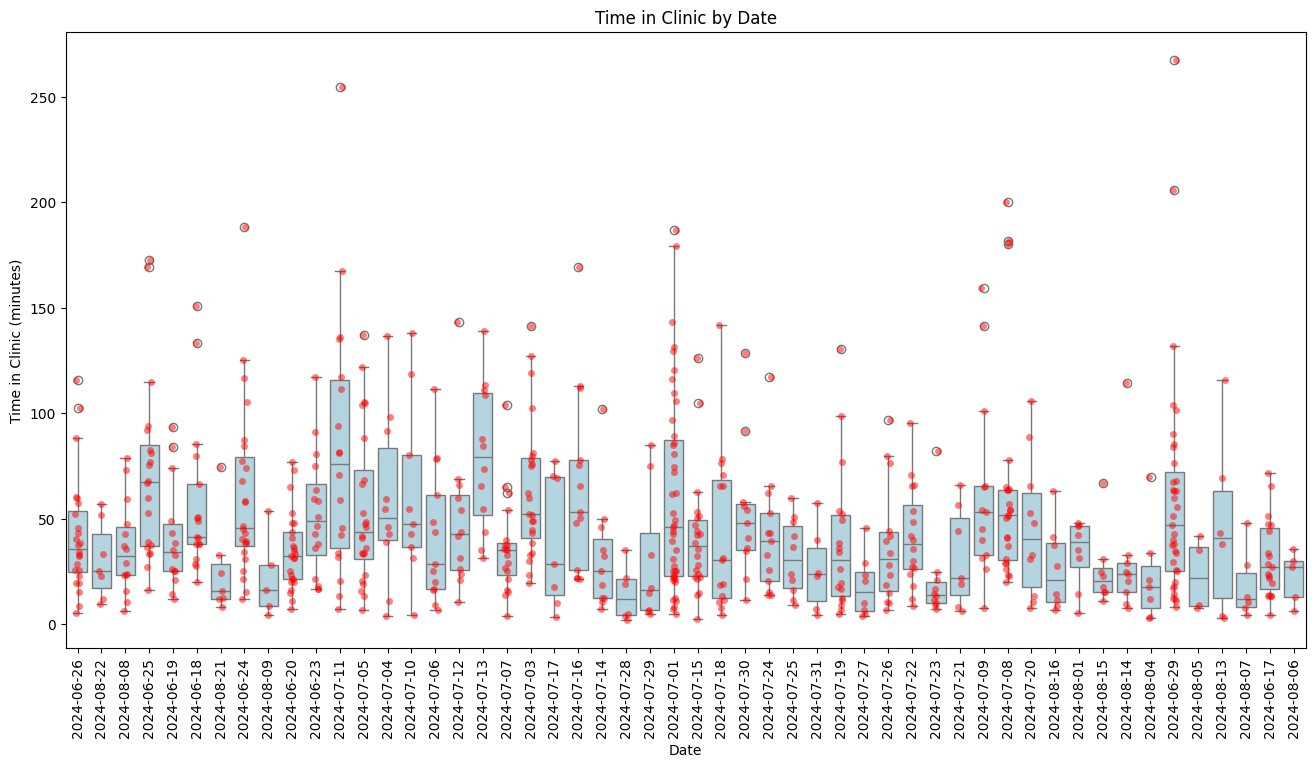

In [17]:
# Convert time_in_clinic to minutes
time_in_clinic_df['time_in_clinic_minutes'] = time_in_clinic_df['time_in_clinic'] / 60

# Create the boxplot with observations
plt.figure(figsize=(16, 8))
sns.boxplot(x='date', y='time_in_clinic_minutes', data=time_in_clinic_df, color='lightblue')
sns.stripplot(x='date', y='time_in_clinic_minutes', data=time_in_clinic_df, color='red', alpha=0.5, jitter=True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Time in Clinic (minutes)')
plt.title('Time in Clinic by Date')

plt.show()

## Check tracking quality

In [18]:
def is_point_in_geometry(x, y, geometries):
	"""
	Checks if a point (x, y) is inside any of the specified rectangular geometries.

	Parameters:
	- x (float): The x-coordinate of the point.
	- y (float): The y-coordinate of the point.
	- geometries (list): A list of geometry dictionaries, each containing 'geometry' key with rectangular coordinates.

	Returns:
	- bool: True if the point is inside any of the geometries, False otherwise.
	"""
	for geometry in geometries:
		rect = geometry['geometry']
		x_coords = [point[0] for point in rect]
		y_coords = [point[1] for point in rect]
		if min(x_coords) <= x <= max(x_coords) and min(y_coords) <= y <= max(y_coords):
			return True
	return False

# Example usage
geometries_to_check = [exit_top, exit_right, exit_left, sputum_area]
x, y = 5.0, 12.0  # Example coordinates
result = is_point_in_geometry(x, y, geometries_to_check)
print(result)  # True if the point is inside any of the geometries, False otherwise

True


In [22]:
# Initialize an empty dataframe to store the results
lost_tracks_df = pd.DataFrame(columns=['date', 'new_track_id', 'lost_entry', 'lost_exit'])

# Loop over all dates in the dates list
for date in dates:
	# Process the data for the current date
	tb_tracks = process_date(date)
	
	# Group by new_track_id and get the first and last track for each ID
	grouped = tb_tracks.groupby('new_track_id')
	first_last_tracks = grouped.agg({'position_x': ['first', 'last'], 'position_y': ['first', 'last']})
	first_last_tracks.columns = ['first_x', 'last_x', 'first_y', 'last_y']
	first_last_tracks = first_last_tracks.reset_index()
	
	# Check if the first and last tracks are in an exit area
	first_last_tracks['lost_entry'] = ~first_last_tracks.apply(
		lambda row: is_point_in_geometry(row['first_x'], row['first_y'], geometries_to_check), axis=1
	)
	first_last_tracks['lost_exit'] = ~first_last_tracks.apply(
		lambda row: is_point_in_geometry(row['last_x'], row['last_y'], geometries_to_check), axis=1
	)
	
	# Add the date column
	first_last_tracks['date'] = date
	
	# Append the results to the dataframe
	lost_tracks_df = pd.concat([
		lost_tracks_df,
		first_last_tracks[['date', 'new_track_id', 'lost_entry', 'lost_exit']]
	], ignore_index=True)

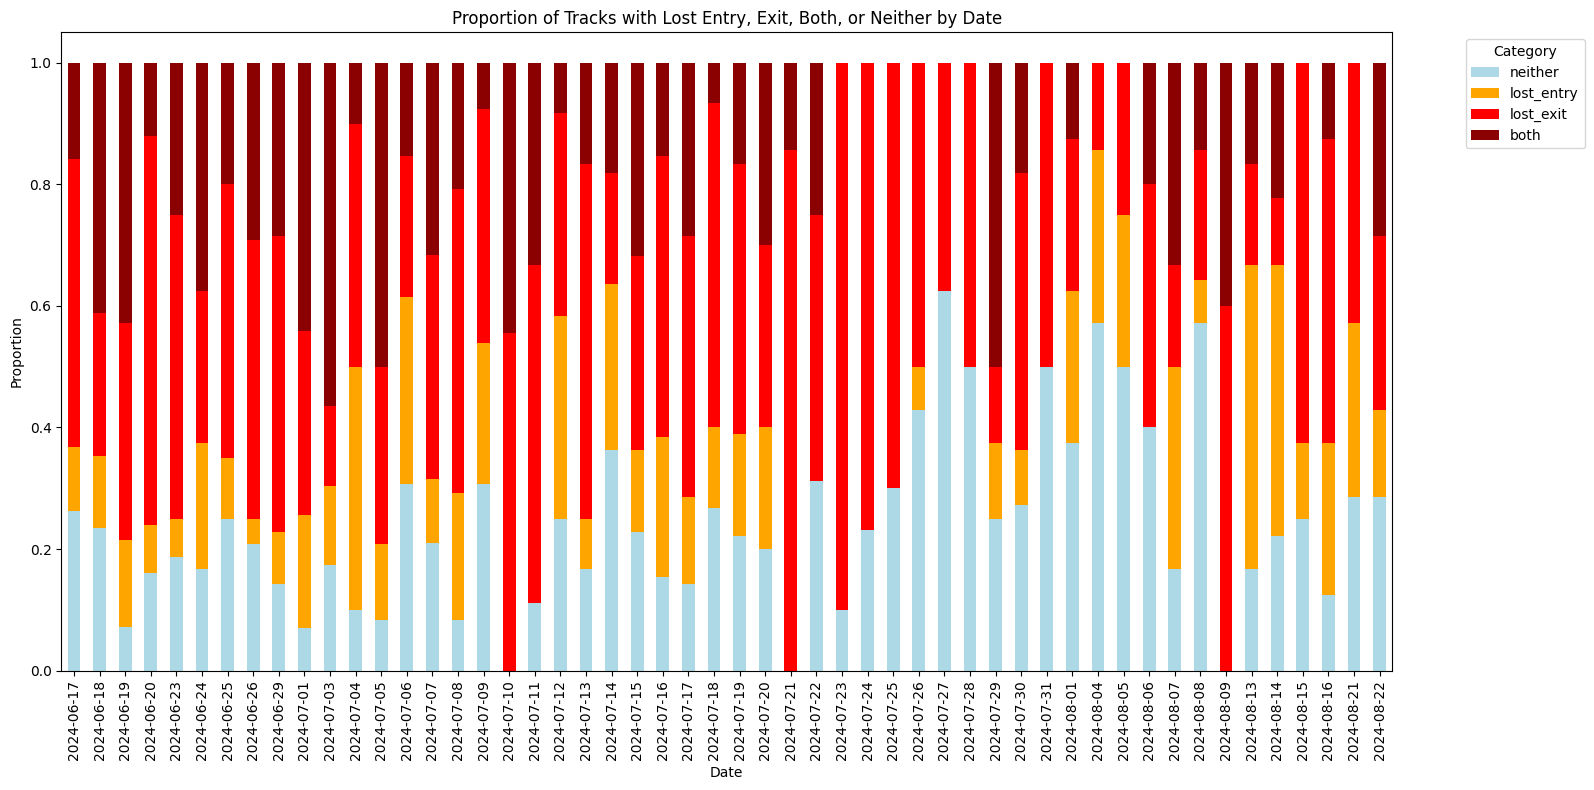

In [25]:
# Update colors and order of stacks
colors = {
    'neither': 'lightblue',
    'lost_entry': 'orange',
    'lost_exit': 'red',
    'both': 'darkred'
}

# Reorder the columns to ensure 'neither' is at the bottom, followed by 'lost_entry', 'lost_exit', and 'both'
proportions = proportions[['neither', 'lost_entry', 'lost_exit', 'both']]

# Plot the stacked bar chart
proportions.plot(kind='bar', stacked=True, figsize=(16, 8), color=[colors[col] for col in proportions.columns])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title('Proportion of Tracks with Lost Entry, Exit, Both, or Neither by Date')
plt.xticks(rotation=90)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


###